In [1]:
%matplotlib inline


# Deidentified face recognition evaluation notebook using eigenfaces and SVMs

This notebook is used to evaluate the effectiveness of the image
deidentification process. 

The dataset is split into a train and test set. 
There are two variants of the test set, one with the original untouched images, and
the other with their deidentified equivalents.

An SVM with eigenfaces is trained on the train set and evaluated on the
untouched test set and the deidentified test set.

In [2]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

import os
import pickle

import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from config import DATA_DIR, FACES_DIR, DEIDENTIFIED_DIR
from utils import get_image_paths, load_faces, get_blurred

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Image crop width and height, and the minimal number of faces for a person to be included in the dataset.

In [3]:
w, h = 94, 125
min_faces = 50

In [4]:
image_files, y, target_names = get_image_paths(DATA_DIR, min_faces)
print(target_names)
n_classes = len(target_names)

['Serena_Williams', 'John_Ashcroft', 'Hugo_Chavez', 'George_W_Bush', 'Ariel_Sharon', 'Jean_Chretien', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Jacques_Chirac', 'Gerhard_Schroeder', 'Junichiro_Koizumi']


Split into train and test set.


In [5]:
# split into a training and testing set
images_train, images_test, y_train, y_test = train_test_split(
    image_files, y, test_size=0.25, random_state=42)

Load train images, original untouched test images, and deidentified test images.

In [6]:
X_train = load_faces(images_train, w, h)
X_train = X_train.reshape((len(X_train), w*h))

X_test = load_faces(images_test, w, h)
X_test = X_test.reshape((len(X_test), w*h))

deidentified_images = \
    get_blurred(DATA_DIR, DEIDENTIFIED_DIR, images_test)
print(deidentified_images[0])
X_test_deidentified = load_faces(deidentified_images, w, h)
X_test_deidentified = X_test_deidentified.reshape((len(X_test_deidentified), w*h))

/home/cizl/dev/rv2/CV-face-de-identification/deidentified/lfw/Jean_Chretien/Jean_Chretien_0045.jpg


Original test image and deidentified test image example.

0
Serena_Williams


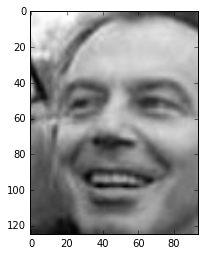

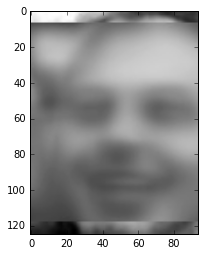

In [7]:
person_id = 53
print(y[person_id])
print(target_names[y[person_id]])

img = X_test[person_id].reshape((h, w))
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

img = X_test_deidentified[person_id].reshape((h, w))
plt.figure()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction


In [8]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_test_deidentified_pca = pca.transform(X_test_deidentified)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1170 faces
done in 4.205s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.657s


Train a SVM classification model


In [9]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 44.680s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Evaluate the model performance on the untouched test set

Quantitative evaluation of the model quality on the test set


In [10]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.100s
                   precision    recall  f1-score   support

  Serena_Williams       0.80      0.86      0.83        14
    John_Ashcroft       0.54      0.78      0.64         9
      Hugo_Chavez       0.77      0.67      0.71        15
    George_W_Bush       0.82      0.92      0.86       132
     Ariel_Sharon       0.62      0.79      0.70        19
    Jean_Chretien       0.79      0.58      0.67        19
     Colin_Powell       0.87      0.92      0.90        52
       Tony_Blair       0.79      0.66      0.72        35
  Donald_Rumsfeld       0.75      0.58      0.66        36
   Jacques_Chirac       0.83      0.36      0.50        14
Gerhard_Schroeder       0.77      0.74      0.75        27
Junichiro_Koizumi       0.84      0.89      0.86        18

      avg / total       0.79      0.79      0.79       390

[[ 12   0   0   0   1   0   0   0   0   0   0   1]
 [  0   7   0   1   0   0   0   1   0   0   0   0]
 [  0   1  1

Qualitative evaluation of the predictions using matplotlib


In [11]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

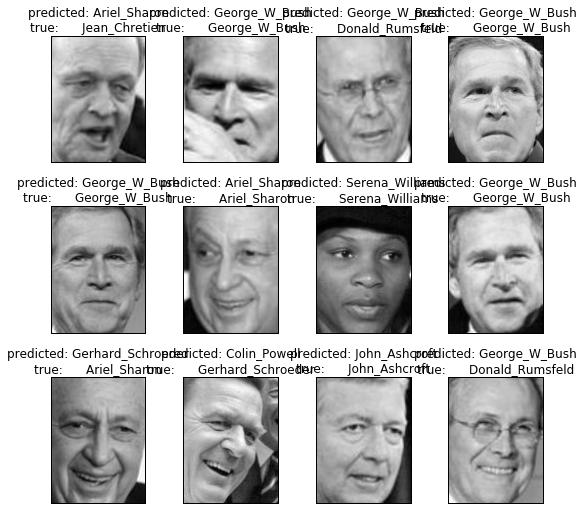

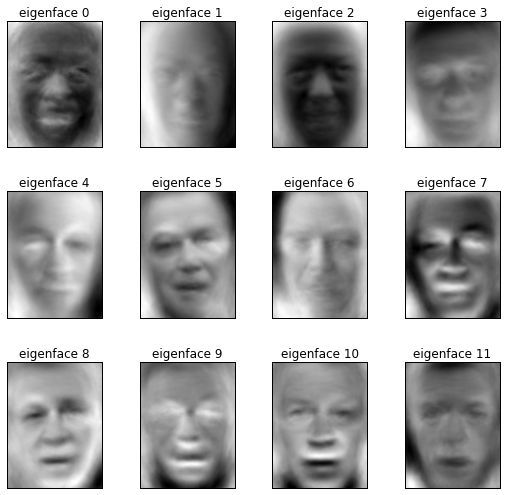

In [12]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Evaluate the model performance on the deidentified test set

In [13]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_deidentified_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.112s
                   precision    recall  f1-score   support

  Serena_Williams       0.57      0.29      0.38        14
    John_Ashcroft       0.23      0.33      0.27         9
      Hugo_Chavez       0.10      0.07      0.08        15
    George_W_Bush       0.63      0.39      0.49       132
     Ariel_Sharon       0.24      0.63      0.35        19
    Jean_Chretien       0.21      0.74      0.33        19
     Colin_Powell       0.42      0.21      0.28        52
       Tony_Blair       0.25      0.23      0.24        35
  Donald_Rumsfeld       0.29      0.61      0.40        36
   Jacques_Chirac       0.20      0.07      0.11        14
Gerhard_Schroeder       0.36      0.19      0.24        27
Junichiro_Koizumi       0.67      0.33      0.44        18

      avg / total       0.43      0.36      0.36       390

[[ 4  0  1  4  3  0  0  0  2  0  0  0]
 [ 0  3  2  0  0  0  0  3  1  0  0  0]
 [ 0  0  1  6  1  1  1  4  1  0  0  

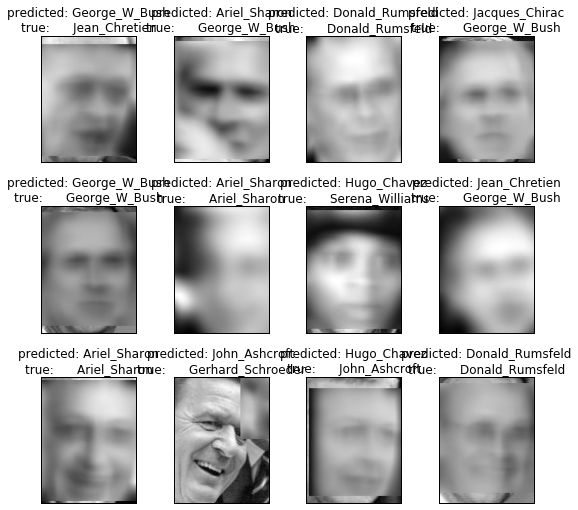

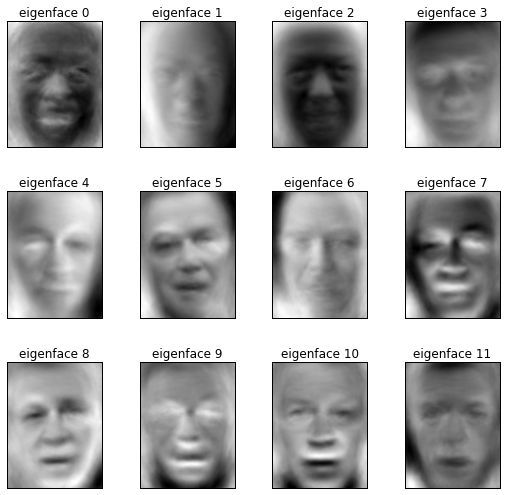

In [14]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test_deidentified, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()